In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install tensorflow
!pip install tflite_support
!pip install flatbuffers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 8.3 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 31.7 MB/s eta 0:00:0000:01:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 22.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 3.7.0
    Uninstalling h5py-3.7.0:
      Successfully uninstalled h5py-3.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.1
    Uninstalling tensorboard-2.10.1:
      Successfully uninstalled tensorboard-2.10.1
ERROR: pip's dependency resolver does not currently take into a

In [3]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix


from tflite_support import metadata_schema_py_generated as _metadata_fb
from tflite_support import metadata as _metadata
import flatbuffers

In [4]:
IMAGES_PATH = "../input/citypersondata/leftImg8bit_trainvaltest/leftImg8bit"
ANNOTS_PATH = "../input/citypersondata/gtBboxCityPersonsWithDangerLevel/gtBboxCityPersonsWithDangerLevel"
BASE_OUTPUT = "output"

TRAIN_FILENAMES = "../input/citypersondata-annot/train.txt"
TEST_FILENAMES = "../input/citypersondata-annot/test.txt"
VAL_FILENAMES = "../input/citypersondata-annot/val.txt"

NUM_CLASSES = 3
OUTPUT_CLASSES = 4 #classes + background

INIT_LR = 1e-4
NUM_EPOCHS = 1
BATCH_SIZE = 16
BUFFER_SIZE = 40

IMG_H = 512#224#512 #384 #360
IMG_W = 512 #224 #512 #512 #480

In [5]:
def getClassFromJson(json_path):
    json_f = open(json_path)
    data = json.load(json_f)
    objects = data["objects"]
    highest_num = 0
    for o in objects:
        danger_level = None
        if "danger_level" in o:
            danger_level = int(o["danger_level"])
        else:
            danger_level = int(o["my_label"])
        
        
        if highest_num < danger_level:
            highest_num = danger_level
        if highest_num == 3:
            break
    return highest_num

In [6]:
trainDataNames = []
trainDataLabels = []
f = open(TRAIN_FILENAMES, "r")
for r in f:
    r = r.split(",") #image path, annotation path
    img_path = r[0]
    annot_path = r[1][:-1] #without \n
    
    class_num = getClassFromJson(annot_path)
    
    trainDataNames.append(img_path)
    trainDataLabels.append(class_num)
    
f.close()

STEPS_PER_EPOCH = len(trainDataNames) // BATCH_SIZE

In [7]:
valDataNames = []
valDataLabels = []
f = open(VAL_FILENAMES, "r")
for r in f:
    r = r.split(",")
    img_path = r[0]
    annot_path = r[1][:-1]

    class_num = getClassFromJson(annot_path)
    
    valDataNames.append(img_path)
    valDataLabels.append(class_num)
    
f.close()

<AxesSubplot:ylabel='count'>

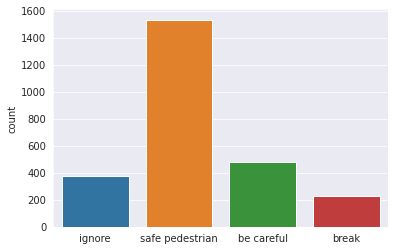

In [8]:
l = []
for i in trainDataLabels:
    if i == 0:
        l.append("ignore")
    elif i == 1:
        l.append("safe pedestrian")
    elif i == 2:
        l.append("be careful")
    elif i == 3:
        l.append("break")
    else:
        print("should not happen")
sns.set_style('darkgrid')
sns.countplot(x=l, order=["ignore", "safe pedestrian", "be careful", "break"])

<AxesSubplot:ylabel='count'>

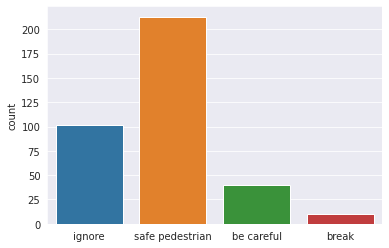

In [9]:
l = []
for i in valDataLabels:
    if i == 0:
        l.append("ignore")
    elif i == 1:
        l.append("safe pedestrian")
    elif i == 2:
        l.append("be careful")
    elif i == 3:
        l.append("break")
    else:
        print("should not happen")
sns.set_style('darkgrid')
sns.countplot(x=l, order=["ignore", "safe pedestrian", "be careful", "break"])

In [10]:
del l

In [11]:
def normalize(input_image, label):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, label

def read_image(image_path, h, w):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    return tf.image.resize(image, [h, w])

def load_image(image_path, label, imageH, imageW):
    input_image = read_image(image_path, imageH, imageW)
    input_image, label = normalize(input_image, label)
    return input_image, label

In [12]:
dataset_train = tf.data.Dataset.from_tensor_slices((trainDataNames, trainDataLabels))
train_images = dataset_train.map(lambda x, y: load_image(x, y, IMG_H, IMG_W), num_parallel_calls=tf.data.AUTOTUNE)


dataset_val = tf.data.Dataset.from_tensor_slices((valDataNames, valDataLabels))
val_images = dataset_val.map(lambda x, y: load_image(x, y, IMG_H, IMG_W), num_parallel_calls=tf.data.AUTOTUNE)

2022-11-16 18:24:38.013149: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [13]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        return inputs, labels

In [14]:
train_batches = (
        train_images
        .cache()
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .repeat()
        .map(Augment())
        .prefetch(buffer_size=tf.data.AUTOTUNE))

In [15]:
val_batches = val_images.batch(BATCH_SIZE)

In [16]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(input_shape = (IMG_H, IMG_W, 3), include_top = False, weights = "imagenet")

16719872/16705208 [==============================] - 1s 0us/step


In [17]:
base_model.trainable = True

In [18]:
model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(64, activation="relu"),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(32, activation="relu"),
                             tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(4, activation="softmax")                                     
                                ])

In [19]:
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss_weights=[1.5, 0.40, 1.7, 3.25],
              metrics=['accuracy'])


ep = 5
history = model.fit(train_batches,epochs = ep , validation_data = val_batches, steps_per_epoch=STEPS_PER_EPOCH)

2022-11-16 18:24:42.612409: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

  1/163 [..............................] - ETA: 1:04:18 - loss: 2.0298 - accuracy: 0.3125

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  2/163 [..............................] - ETA: 17:49 - loss: 2.0771 - accuracy: 0.2812  

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  3/163 [..............................] - ETA: 17:44 - loss: 2.0968 - accuracy: 0.2500

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  4/163 [..............................] - ETA: 17:34 - loss: 2.1108 - accuracy: 0.2344

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  5/163 [..............................] - ETA: 17:30 - loss: 2.1141 - accuracy: 0.2375

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  6/163 [>.............................] - ETA: 17:20 - loss: 2.1277 - accuracy: 0.2188

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  7/163 [>.............................] - ETA: 17:09 - loss: 2.1171 - accuracy: 0.2232

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  8/163 [>.............................] - ETA: 17:00 - loss: 2.1215 - accuracy: 0.2188

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  9/163 [>.............................] - ETA: 16:59 - loss: 2.1115 - accuracy: 0.2361

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 10/163 [>.............................] - ETA: 16:50 - loss: 2.1192 - accuracy: 0.2313

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 11/163 [=>............................] - ETA: 16:43 - loss: 2.1295 - accuracy: 0.2159

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 12/163 [=>............................] - ETA: 16:37 - loss: 2.1301 - accuracy: 0.2135

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 13/163 [=>............................] - ETA: 16:28 - loss: 2.1244 - accuracy: 0.2067

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 14/163 [=>............................] - ETA: 16:26 - loss: 2.1217 - accuracy: 0.2054

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 15/163 [=>............................] - ETA: 16:18 - loss: 2.1332 - accuracy: 0.1917

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 16/163 [=>............................] - ETA: 16:10 - loss: 2.1327 - accuracy: 0.1953

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 17/163 [==>...........................] - ETA: 16:02 - loss: 2.1371 - accuracy: 0.1838

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 18/163 [==>...........................] - ETA: 15:54 - loss: 2.1438 - accuracy: 0.1771

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 19/163 [==>...........................] - ETA: 15:51 - loss: 2.1440 - accuracy: 0.1776

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 20/163 [==>...........................] - ETA: 15:44 - loss: 2.1402 - accuracy: 0.1813

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 21/163 [==>...........................] - ETA: 15:36 - loss: 2.1363 - accuracy: 0.1815

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 22/163 [===>..........................] - ETA: 15:29 - loss: 2.1328 - accuracy: 0.1761

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 23/163 [===>..........................] - ETA: 15:21 - loss: 2.1315 - accuracy: 0.1739

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 24/163 [===>..........................] - ETA: 15:17 - loss: 2.1297 - accuracy: 0.1745

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 25/163 [===>..........................] - ETA: 15:10 - loss: 2.1322 - accuracy: 0.1750

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 26/163 [===>..........................] - ETA: 15:03 - loss: 2.1296 - accuracy: 0.1779

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 27/163 [===>..........................] - ETA: 14:55 - loss: 2.1301 - accuracy: 0.1782

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 28/163 [====>.........................] - ETA: 14:48 - loss: 2.1333 - accuracy: 0.1763

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 29/163 [====>.........................] - ETA: 14:45 - loss: 2.1342 - accuracy: 0.1767

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 30/163 [====>.........................] - ETA: 14:37 - loss: 2.1352 - accuracy: 0.1771

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 31/163 [====>.........................] - ETA: 14:30 - loss: 2.1329 - accuracy: 0.1835

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 32/163 [====>.........................] - ETA: 14:23 - loss: 2.1315 - accuracy: 0.1816

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 33/163 [=====>........................] - ETA: 14:15 - loss: 2.1303 - accuracy: 0.1761

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 34/163 [=====>........................] - ETA: 14:11 - loss: 2.1247 - accuracy: 0.1820

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 35/163 [=====>........................] - ETA: 14:04 - loss: 2.1171 - accuracy: 0.1911

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 36/163 [=====>........................] - ETA: 13:57 - loss: 2.1158 - accuracy: 0.1944

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 37/163 [=====>........................] - ETA: 13:50 - loss: 2.1150 - accuracy: 0.1959

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 38/163 [=====>........................] - ETA: 13:44 - loss: 2.1135 - accuracy: 0.1990

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 39/163 [======>.......................] - ETA: 13:37 - loss: 2.1096 - accuracy: 0.2035

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 40/163 [======>.......................] - ETA: 13:30 - loss: 2.1079 - accuracy: 0.2078

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 41/163 [======>.......................] - ETA: 13:23 - loss: 2.1054 - accuracy: 0.2104

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 42/163 [======>.......................] - ETA: 13:16 - loss: 2.1053 - accuracy: 0.2113

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 43/163 [======>.......................] - ETA: 13:10 - loss: 2.1036 - accuracy: 0.2108

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 44/163 [=======>......................] - ETA: 13:03 - loss: 2.1050 - accuracy: 0.2074

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 45/163 [=======>......................] - ETA: 12:57 - loss: 2.1001 - accuracy: 0.2139

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 46/163 [=======>......................] - ETA: 12:50 - loss: 2.1001 - accuracy: 0.2133

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 47/163 [=======>......................] - ETA: 12:43 - loss: 2.0994 - accuracy: 0.2114

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 48/163 [=======>......................] - ETA: 12:37 - loss: 2.0985 - accuracy: 0.2096

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 49/163 [========>.....................] - ETA: 12:31 - loss: 2.0967 - accuracy: 0.2143

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 50/163 [========>.....................] - ETA: 12:24 - loss: 2.0938 - accuracy: 0.2175

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 51/163 [========>.....................] - ETA: 12:17 - loss: 2.0905 - accuracy: 0.2194

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 52/163 [========>.....................] - ETA: 12:10 - loss: 2.0885 - accuracy: 0.2236

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 53/163 [========>.....................] - ETA: 12:04 - loss: 2.0859 - accuracy: 0.2276

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 54/163 [========>.....................] - ETA: 11:57 - loss: 2.0826 - accuracy: 0.2315

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 55/163 [=========>....................] - ETA: 11:50 - loss: 2.0809 - accuracy: 0.2330

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 56/163 [=========>....................] - ETA: 11:44 - loss: 2.0791 - accuracy: 0.2355

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 57/163 [=========>....................] - ETA: 11:37 - loss: 2.0772 - accuracy: 0.2368

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 58/163 [=========>....................] - ETA: 11:31 - loss: 2.0770 - accuracy: 0.2371

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 59/163 [=========>....................] - ETA: 11:24 - loss: 2.0786 - accuracy: 0.2331

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 60/163 [==========>...................] - ETA: 11:17 - loss: 2.0785 - accuracy: 0.2333

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 61/163 [==========>...................] - ETA: 11:11 - loss: 2.0776 - accuracy: 0.2326

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 62/163 [==========>...................] - ETA: 11:04 - loss: 2.0775 - accuracy: 0.2329

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 63/163 [==========>...................] - ETA: 10:58 - loss: 2.0743 - accuracy: 0.2381

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 64/163 [==========>...................] - ETA: 10:51 - loss: 2.0734 - accuracy: 0.2393

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 65/163 [==========>...................] - ETA: 10:44 - loss: 2.0715 - accuracy: 0.2413

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 66/163 [===========>..................] - ETA: 10:38 - loss: 2.0711 - accuracy: 0.2415

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 67/163 [===========>..................] - ETA: 10:31 - loss: 2.0695 - accuracy: 0.2444

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 68/163 [===========>..................] - ETA: 10:25 - loss: 2.0680 - accuracy: 0.2463

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 69/163 [===========>..................] - ETA: 10:18 - loss: 2.0684 - accuracy: 0.2473

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 70/163 [===========>..................] - ETA: 10:11 - loss: 2.0670 - accuracy: 0.2482

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 71/163 [============>.................] - ETA: 10:04 - loss: 2.0661 - accuracy: 0.2500

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 72/163 [============>.................] - ETA: 9:58 - loss: 2.0640 - accuracy: 0.2552 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 73/163 [============>.................] - ETA: 9:51 - loss: 2.0638 - accuracy: 0.2560

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 74/163 [============>.................] - ETA: 9:45 - loss: 2.0651 - accuracy: 0.2551

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 75/163 [============>.................] - ETA: 9:38 - loss: 2.0643 - accuracy: 0.2550

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 76/163 [============>.................] - ETA: 9:31 - loss: 2.0635 - accuracy: 0.2558

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 77/163 [=============>................] - ETA: 9:25 - loss: 2.0636 - accuracy: 0.2565

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 78/163 [=============>................] - ETA: 9:18 - loss: 2.0620 - accuracy: 0.2596

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 79/163 [=============>................] - ETA: 9:12 - loss: 2.0624 - accuracy: 0.2595

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 80/163 [=============>................] - ETA: 9:05 - loss: 2.0599 - accuracy: 0.2625

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 81/163 [=============>................] - ETA: 8:58 - loss: 2.0578 - accuracy: 0.2639

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 82/163 [==============>...............] - ETA: 8:52 - loss: 2.0565 - accuracy: 0.2660

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 83/163 [==============>...............] - ETA: 8:45 - loss: 2.0546 - accuracy: 0.2681

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 84/163 [==============>...............] - ETA: 8:39 - loss: 2.0534 - accuracy: 0.2701

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 85/163 [==============>...............] - ETA: 8:32 - loss: 2.0538 - accuracy: 0.2684

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 86/163 [==============>...............] - ETA: 8:25 - loss: 2.0545 - accuracy: 0.2682

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 87/163 [===============>..............] - ETA: 8:19 - loss: 2.0529 - accuracy: 0.2694

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 88/163 [===============>..............] - ETA: 8:12 - loss: 2.0514 - accuracy: 0.2727

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 89/163 [===============>..............] - ETA: 8:06 - loss: 2.0513 - accuracy: 0.2746

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 90/163 [===============>..............] - ETA: 7:59 - loss: 2.0488 - accuracy: 0.2792

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 91/163 [===============>..............] - ETA: 7:52 - loss: 2.0485 - accuracy: 0.2802

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 92/163 [===============>..............] - ETA: 7:46 - loss: 2.0479 - accuracy: 0.2806

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 93/163 [================>.............] - ETA: 7:40 - loss: 2.0462 - accuracy: 0.2816

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 94/163 [================>.............] - ETA: 7:33 - loss: 2.0461 - accuracy: 0.2812

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 95/163 [================>.............] - ETA: 7:26 - loss: 2.0452 - accuracy: 0.2809

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 96/163 [================>.............] - ETA: 7:20 - loss: 2.0433 - accuracy: 0.2845

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 97/163 [================>.............] - ETA: 7:13 - loss: 2.0445 - accuracy: 0.2835

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 98/163 [=================>............] - ETA: 7:07 - loss: 2.0453 - accuracy: 0.2838

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 99/163 [=================>............] - ETA: 7:00 - loss: 2.0435 - accuracy: 0.2860

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


100/163 [=================>............] - ETA: 6:53 - loss: 2.0441 - accuracy: 0.2856

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


101/163 [=================>............] - ETA: 6:47 - loss: 2.0440 - accuracy: 0.2871

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


102/163 [=================>............] - ETA: 6:40 - loss: 2.0444 - accuracy: 0.2892

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


103/163 [=================>............] - ETA: 6:34 - loss: 2.0427 - accuracy: 0.2907

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


104/163 [==================>...........] - ETA: 6:27 - loss: 2.0436 - accuracy: 0.2897

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


105/163 [==================>...........] - ETA: 6:20 - loss: 2.0427 - accuracy: 0.2911

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


106/163 [==================>...........] - ETA: 6:14 - loss: 2.0421 - accuracy: 0.2919

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


107/163 [==================>...........] - ETA: 6:07 - loss: 2.0418 - accuracy: 0.2915

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


108/163 [==================>...........] - ETA: 6:01 - loss: 2.0400 - accuracy: 0.2940

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


109/163 [===================>..........] - ETA: 5:54 - loss: 2.0384 - accuracy: 0.2959

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


110/163 [===================>..........] - ETA: 5:47 - loss: 2.0377 - accuracy: 0.2972

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


111/163 [===================>..........] - ETA: 5:41 - loss: 2.0359 - accuracy: 0.2984

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


112/163 [===================>..........] - ETA: 5:34 - loss: 2.0353 - accuracy: 0.2985

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


113/163 [===================>..........] - ETA: 5:28 - loss: 2.0343 - accuracy: 0.2992

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


114/163 [===================>..........] - ETA: 5:21 - loss: 2.0331 - accuracy: 0.2999

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


115/163 [====================>.........] - ETA: 5:15 - loss: 2.0307 - accuracy: 0.3027

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


116/163 [====================>.........] - ETA: 5:08 - loss: 2.0318 - accuracy: 0.3012

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


117/163 [====================>.........] - ETA: 5:02 - loss: 2.0304 - accuracy: 0.3029

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


118/163 [====================>.........] - ETA: 4:55 - loss: 2.0308 - accuracy: 0.3024

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


119/163 [====================>.........] - ETA: 4:48 - loss: 2.0290 - accuracy: 0.3041

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


120/163 [=====================>........] - ETA: 4:42 - loss: 2.0291 - accuracy: 0.3047

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


121/163 [=====================>........] - ETA: 4:35 - loss: 2.0293 - accuracy: 0.3058

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


122/163 [=====================>........] - ETA: 4:29 - loss: 2.0289 - accuracy: 0.3074

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


123/163 [=====================>........] - ETA: 4:22 - loss: 2.0275 - accuracy: 0.3100

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


124/163 [=====================>........] - ETA: 4:15 - loss: 2.0255 - accuracy: 0.3115

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


125/163 [======================>.......] - ETA: 4:09 - loss: 2.0262 - accuracy: 0.3110

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


126/163 [======================>.......] - ETA: 4:02 - loss: 2.0254 - accuracy: 0.3120

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


127/163 [======================>.......] - ETA: 3:56 - loss: 2.0245 - accuracy: 0.3130

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


128/163 [======================>.......] - ETA: 3:49 - loss: 2.0231 - accuracy: 0.3159

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


129/163 [======================>.......] - ETA: 3:42 - loss: 2.0222 - accuracy: 0.3178

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


130/163 [======================>.......] - ETA: 3:36 - loss: 2.0224 - accuracy: 0.3168

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


131/163 [=======================>......] - ETA: 3:29 - loss: 2.0231 - accuracy: 0.3163

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


132/163 [=======================>......] - ETA: 3:23 - loss: 2.0229 - accuracy: 0.3153

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


133/163 [=======================>......] - ETA: 3:16 - loss: 2.0209 - accuracy: 0.3177

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


134/163 [=======================>......] - ETA: 3:10 - loss: 2.0209 - accuracy: 0.3181

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


135/163 [=======================>......] - ETA: 3:03 - loss: 2.0195 - accuracy: 0.3199

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


136/163 [========================>.....] - ETA: 2:57 - loss: 2.0186 - accuracy: 0.3212

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


137/163 [========================>.....] - ETA: 2:50 - loss: 2.0176 - accuracy: 0.3230

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


138/163 [========================>.....] - ETA: 2:43 - loss: 2.0169 - accuracy: 0.3243

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


139/163 [========================>.....] - ETA: 2:37 - loss: 2.0155 - accuracy: 0.3255

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


140/163 [========================>.....] - ETA: 2:30 - loss: 2.0142 - accuracy: 0.3268

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


141/163 [========================>.....] - ETA: 2:24 - loss: 2.0136 - accuracy: 0.3276

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


142/163 [=========================>....] - ETA: 2:17 - loss: 2.0137 - accuracy: 0.3283

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


143/163 [=========================>....] - ETA: 2:11 - loss: 2.0127 - accuracy: 0.3295

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


144/163 [=========================>....] - ETA: 2:04 - loss: 2.0115 - accuracy: 0.3312

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


145/163 [=========================>....] - ETA: 1:57 - loss: 2.0101 - accuracy: 0.3332

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


146/163 [=========================>....] - ETA: 1:51 - loss: 2.0089 - accuracy: 0.3348

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


147/163 [==========================>...] - ETA: 1:44 - loss: 2.0089 - accuracy: 0.3346

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


148/163 [==========================>...] - ETA: 1:38 - loss: 2.0082 - accuracy: 0.3353

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


149/163 [==========================>...] - ETA: 1:31 - loss: 2.0062 - accuracy: 0.3381

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


150/163 [==========================>...] - ETA: 1:25 - loss: 2.0050 - accuracy: 0.3396

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


151/163 [==========================>...] - ETA: 1:18 - loss: 2.0040 - accuracy: 0.3406

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


152/163 [==========================>...] - ETA: 1:12 - loss: 2.0037 - accuracy: 0.3417

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


153/163 [===========================>..] - ETA: 1:05 - loss: 2.0022 - accuracy: 0.3427

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


154/163 [===========================>..] - ETA: 58s - loss: 2.0006 - accuracy: 0.3446 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


155/163 [===========================>..] - ETA: 52s - loss: 1.9985 - accuracy: 0.3468

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


156/163 [===========================>..] - ETA: 45s - loss: 1.9978 - accuracy: 0.3486

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


157/163 [===========================>..] - ETA: 39s - loss: 1.9969 - accuracy: 0.3503

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


158/163 [============================>.] - ETA: 32s - loss: 1.9956 - accuracy: 0.3525

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


159/163 [============================>.] - ETA: 26s - loss: 1.9952 - accuracy: 0.3530

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


163/163 [==============================] - ETA: 0s - loss: 1.9905 - accuracy: 0.3562

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

163/163 [==============================] - 1131s 7s/step - loss: 1.9905 - accuracy: 0.3562 - val_loss: 2.0732 - val_accuracy: 0.1671
Epoch 2/5
163/163 [==============================] - ETA: 0s - loss: 1.7850 - accuracy: 0.5332

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

163/163 [==============================] - 1033s 6s/step - loss: 1.7850 - accuracy: 0.5332 - val_loss: 2.0572 - val_accuracy: 0.4685
Epoch 3/5
163/163 [==============================] - ETA: 0s - loss: 1.6631 - accuracy: 0.5663

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

163/163 [==============================] - 1013s 6s/step - loss: 1.6631 - accuracy: 0.5663 - val_loss: 1.9065 - val_accuracy: 0.5342
Epoch 4/5
163/163 [==============================] - ETA: 0s - loss: 1.5906 - accuracy: 0.5929

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

163/163 [==============================] - 1011s 6s/step - loss: 1.5906 - accuracy: 0.5929 - val_loss: 1.9982 - val_accuracy: 0.3178
Epoch 5/5
163/163 [==============================] - ETA: 0s - loss: 1.5400 - accuracy: 0.5937

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

163/163 [==============================] - 1010s 6s/step - loss: 1.5400 - accuracy: 0.5937 - val_loss: 1.9224 - val_accuracy: 0.4438


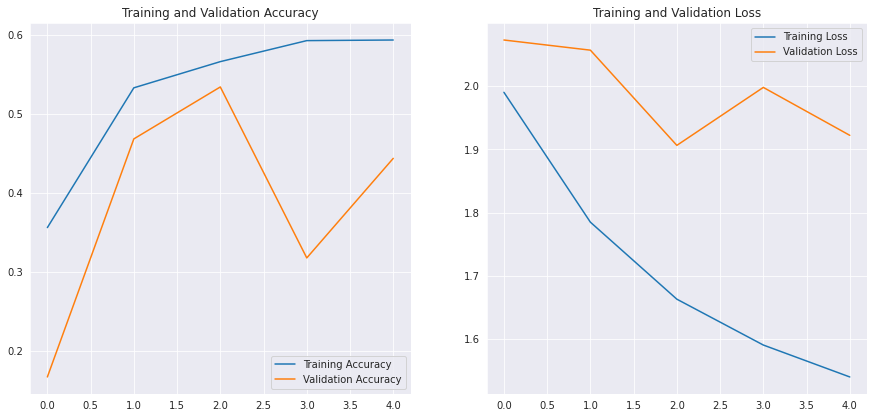

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(ep)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
testDataLabels = []
test_images = []
f = open(TEST_FILENAMES, "r")
for r in f:
    r = r.split(",")
    img_path = r[0]
    annot_path = r[1][:-1]
    img_arr = cv2.imread(img_path)[...,::-1] #convert BGR to RGB format
    resized_arr = cv2.resize(img_arr, (IMG_H, IMG_W))

    class_num = getClassFromJson(annot_path)
    
    testDataLabels.append(class_num)
    test_images.append(resized_arr)
    
f.close()

<AxesSubplot:ylabel='count'>

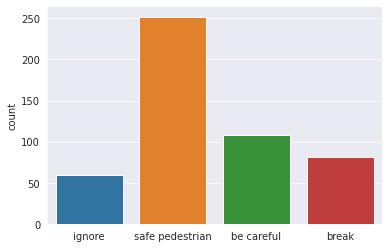

In [22]:
l = []
for i in testDataLabels:
    if i == 0:
        l.append("ignore")
    elif i == 1:
        l.append("safe pedestrian")
    elif i == 2:
        l.append("be careful")
    elif i == 3:
        l.append("break")
    else:
        print("should not happen")
sns.set_style('darkgrid')
sns.countplot(x=l, order=["ignore", "safe pedestrian", "be careful", "break"])

In [23]:
#dataset_test = tf.data.Dataset.from_tensor_slices((testDataNames, testDataLabels))
#test_images = dataset_test.map(lambda x, y: load_image(x, y, IMG_H, IMG_W), num_parallel_calls=tf.data.AUTOTUNE)
test_images = np.array(test_images) / 255
test_images.reshape(-1, IMG_H, IMG_W, 1)

array([[[[0.12156863],
         [0.1372549 ],
         [0.11372549],
         ...,
         [0.27058824],
         [0.19607843],
         [0.2745098 ]],

        [[0.24705882],
         [0.20392157],
         [0.29411765],
         ...,
         [0.61176471],
         [0.50980392],
         [0.66666667]],

        [[0.76862745],
         [0.66666667],
         [0.50588235],
         ...,
         [0.49803922],
         [0.60784314],
         [0.59607843]],

        ...,

        [[0.09803922],
         [0.08627451],
         [0.06666667],
         ...,
         [0.42745098],
         [0.54117647],
         [0.52941176]],

        [[0.16470588],
         [0.23529412],
         [0.21176471],
         ...,
         [0.41568627],
         [0.36078431],
         [0.44705882]],

        [[0.42745098],
         [0.36470588],
         [0.44313725],
         ...,
         [0.09019608],
         [0.08235294],
         [0.07058824]]],


       [[[0.10196078],
         [0.09411765],
         [0.07

In [24]:
predictions = np.argmax(model.predict(test_images, batch_size=BATCH_SIZE), axis=-1)
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(testDataLabels, predictions, target_names = ['Ignore (Class 0)','safe pedestrian (Class 1)', 'Be careful (Class 2)', 'Break (Class 3)']))

                           precision    recall  f1-score   support

         Ignore (Class 0)       0.33      0.02      0.03        59
safe pedestrian (Class 1)       0.51      0.92      0.66       252
     Be careful (Class 2)       0.21      0.06      0.10       108
          Break (Class 3)       0.27      0.04      0.07        81

                 accuracy                           0.48       500
                macro avg       0.33      0.26      0.21       500
             weighted avg       0.39      0.48      0.37       500



In [25]:
confusion = tf.math.confusion_matrix(labels=testDataLabels, predictions=predictions, num_classes=4)
print(confusion)

tf.Tensor(
[[  1  52   6   0]
 [  1 231  13   7]
 [  0 100   7   1]
 [  1  70   7   3]], shape=(4, 4), dtype=int32)


In [26]:
saved_model_dir = 'saved_models'
tf.saved_model.save(model, saved_model_dir)

2022-11-16 19:54:32.825081: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [27]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

2022-11-16 19:55:15.818138: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:351] Ignored output_format.
2022-11-16 19:55:15.818207: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored drop_control_dependency.
2022-11-16 19:55:15.818217: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored change_concat_input_ranges.
2022-11-16 19:55:15.820680: I tensorflow/cc/saved_model/reader.cc:38] Reading SavedModel from: saved_models
2022-11-16 19:55:15.910259: I tensorflow/cc/saved_model/reader.cc:90] Reading meta graph with tags { serve }
2022-11-16 19:55:15.910346: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: saved_models
2022-11-16 19:55:15.910615: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-11-16 19:55:16.259915: I tensorflow/cc/saved_mo

In [28]:
with open('mobilenet2_16_11_5pm.tflite', 'wb') as f:
  f.write(tflite_model)

class ModelSpecificInfo(object):
  """Holds information that is specificly tied to an image classifier."""

  def __init__(self, name, version, image_width, image_height, image_min,
               image_max, mean, std, num_classes, author):
    self.name = name
    self.version = version
    self.image_width = image_width
    self.image_height = image_height
    self.image_min = image_min
    self.image_max = image_max
    self.mean = mean
    self.std = std
    self.num_classes = num_classes
    self.author = author

_MODEL_INFO = {
    "mobilenet2_16_11_5pm.tflite":
        ModelSpecificInfo(
            name="MobileNetV2",
            version="v1",
            image_width=512,
            image_height=512,
            image_min=0,
            image_max=255,
            mean=[127.5],
            std=[127.5],
            num_classes=4,
            author="TensorFlow")
}

In [29]:
class MetadataPopulatorForImageClassifier(object):
  """Populates the metadata for an image classifier."""

  def __init__(self, model_file, model_info, label_file_path):
    self.model_file = model_file
    self.model_info = model_info
    self.label_file_path = label_file_path
    self.metadata_buf = None

  def populate(self):
    """Creates metadata and then populates it for an image classifier."""
    self._create_metadata()
    self._populate_metadata()

  def _create_metadata(self):
    """Creates the metadata for an image classifier."""

    # Creates model info.
    model_meta = _metadata_fb.ModelMetadataT()
    model_meta.name = self.model_info.name
    model_meta.description = ("Identify the most prominent object in the "
                              "image from a set of %d categories." %
                              self.model_info.num_classes)
    model_meta.version = self.model_info.version
    model_meta.author = self.model_info.author
    model_meta.license = ("Apache License. Version 2.0 "
                          "http://www.apache.org/licenses/LICENSE-2.0.")

    # Creates input info.
    input_meta = _metadata_fb.TensorMetadataT()
    input_meta.name = "image"
    input_meta.description = (
        "Input image to be classified. The expected image is {0} x {1}, with "
        "three channels (red, blue, and green) per pixel. Each value in the "
        "tensor is a single byte between {2} and {3}.".format(
            self.model_info.image_width, self.model_info.image_height,
            self.model_info.image_min, self.model_info.image_max))
    input_meta.content = _metadata_fb.ContentT()
    input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
    input_meta.content.contentProperties.colorSpace = (
        _metadata_fb.ColorSpaceType.RGB)
    input_meta.content.contentPropertiesType = (
        _metadata_fb.ContentProperties.ImageProperties)
    input_normalization = _metadata_fb.ProcessUnitT()
    input_normalization.optionsType = (
        _metadata_fb.ProcessUnitOptions.NormalizationOptions)
    input_normalization.options = _metadata_fb.NormalizationOptionsT()
    input_normalization.options.mean = self.model_info.mean
    input_normalization.options.std = self.model_info.std
    input_meta.processUnits = [input_normalization]
    input_stats = _metadata_fb.StatsT()
    input_stats.max = [self.model_info.image_max]
    input_stats.min = [self.model_info.image_min]
    input_meta.stats = input_stats

    # Creates output info.
    output_meta = _metadata_fb.TensorMetadataT()
    output_meta.name = "probability"
    output_meta.description = "Probabilities of the %d labels respectively." % self.model_info.num_classes
    output_meta.content = _metadata_fb.ContentT()
    output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
    output_meta.content.contentPropertiesType = (
        _metadata_fb.ContentProperties.FeatureProperties)
    output_stats = _metadata_fb.StatsT()
    output_stats.max = [1.0]
    output_stats.min = [0.0]
    output_meta.stats = output_stats
    label_file = _metadata_fb.AssociatedFileT()
    label_file.name = os.path.basename(self.label_file_path)
    label_file.description = "Labels for objects that the model can recognize."
    label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
    output_meta.associatedFiles = [label_file]

    # Creates subgraph info.
    subgraph = _metadata_fb.SubGraphMetadataT()
    subgraph.inputTensorMetadata = [input_meta]
    subgraph.outputTensorMetadata = [output_meta]
    model_meta.subgraphMetadata = [subgraph]

    b = flatbuffers.Builder(0)
    b.Finish(
        model_meta.Pack(b),
        _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
    self.metadata_buf = b.Output()

  def _populate_metadata(self):
    """Populates metadata and label file to the model file."""
    populator = _metadata.MetadataPopulator.with_model_file(self.model_file)
    populator.load_metadata_buffer(self.metadata_buf)
    populator.load_associated_files([self.label_file_path])
    populator.populate()


In [30]:
import flatbuffers
model_file = "mobilenet2_16_11_5pm.tflite"
model_basename = os.path.basename(model_file)

export_model_path = os.path.join(saved_model_dir, model_basename)

# Copies model_file to export_path.
tf.io.gfile.copy(model_file, export_model_path, overwrite=True)

# Generate the metadata objects and put them in the model file
populator = MetadataPopulatorForImageClassifier(
  export_model_path, _MODEL_INFO.get(model_file), "../input/citypersondata-annot/labels.txt")
populator.populate()

In [31]:
# Validate the output model file by reading the metadata and produce
# a json file with the metadata under the export path
displayer = _metadata.MetadataDisplayer.with_model_file(export_model_path)
export_json_file = os.path.join(saved_model_dir, os.path.splitext(model_basename)[0] + ".json")
json_file = displayer.get_metadata_json()
with open(export_json_file, "w") as f:
    f.write(json_file)

In [32]:
print("Finished populating metadata and associated file to the model:")
print(model_file)
print("The metadata json file has been saved to:")
print(export_json_file)
print("The associated file that has been been packed to the model is:")
print(displayer.get_packed_associated_file_list())

Finished populating metadata and associated file to the model:
mobilenet2_16_11_5pm.tflite
The metadata json file has been saved to:
saved_models/mobilenet2_16_11_5pm.json
The associated file that has been been packed to the model is:
['labels.txt']
